In [2]:
import pandas as pd

In [3]:
dfstar = pd.read_csv('star_classification.csv')

In [4]:
dfstar.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237660e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543780e+18,GALAXY,0.634794,5812,56354,171
1,1.237660e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176010e+19,GALAXY,0.779136,10445,58158,427
2,1.237660e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237660e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030110e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891860e+18,GALAXY,0.116123,6121,56187,842


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = dfstar.drop('class', axis=1) #.select_dtypes(['number'])
y = dfstar['class']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=912)

In [8]:
dfstar.isna().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [11]:
y_train

11097    GALAXY
48384    GALAXY
56597      STAR
19530    GALAXY
59939       QSO
          ...  
32948    GALAXY
11655    GALAXY
48204      STAR
25216       QSO
4949     GALAXY
Name: class, Length: 80000, dtype: object

In [12]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)

In [13]:
y_train

array([0, 0, 2, ..., 2, 1, 0])

In [14]:
from xgboost import XGBClassifier
clf_xg = XGBClassifier(n_estimators=100, class_weight='balanced', max_depth=3)
clf_xg.fit(X_train, y_train)

C:\Users\arnav\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf_xg, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
# report performance
# distribution as it takes the harmonic mean of precision and recall.
print('F1 score: %.3f (%.3f)' % (n_scores.mean(), n_scores.std() * 2))

F1 score: 0.974 (0.004)


## Feature Selection

<AxesSubplot:>

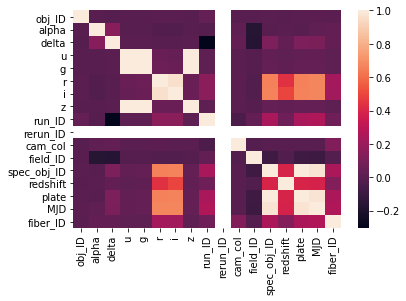

In [17]:
import seaborn as sn
import matplotlib.pyplot as plt
# checking for collinearity between the predictor features
sn.heatmap(X_train.corr())

In [21]:
# Dropping rerun_ID due to high collinearity with all other features
X_train.drop(["rerun_ID"], axis = 1, inplace = True)

C:\Users\arnav\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:>

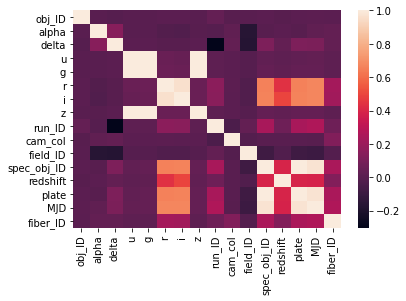

In [22]:
sn.heatmap(X_train.corr())

In [23]:
# Using the Variance Threshold (Filter Method) for feature selection to 
# remove all low variance features
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold

In [25]:
# Re-running with the threshold of 0.04
sel = VarianceThreshold(threshold=(0.1));
sel = sel.fit(X_train);

X_train_new = sel.transform(X_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf_xg, X_train_new, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
# report performance
print('F1 score: %.3f (%.3f)'  % (n_scores.mean(), n_scores.std() * 2))

# Check the number of features in the new training dataset
X_train_new.shape

F1 score: 0.974 (0.004)


(80000, 16)

## Hyperparameter Tuning

For hyperparameter tuning, using grid search to optimize the hyperparameters. In the first round I specified different combination of the hyperparameters such as max_depth (maximum tree depth), learning_rate, gamma (parameter that controls the pruning), and regularization parameter lambda. Scale_pos_weight represents the ratio of number of negative class to the positive class.

In [19]:
# Defining the possible values for hyperparameters for the first round of grid search
param_grid = {
'max_depth': [3, 4, 5],
'learning_rate': [0.01, 0.05, 0.1],
'gamma': [0, 0.25, 1],
'reg_lambda': [0, 1.0, 10.0],
'scale_pos_weight': [1, 2, 5]
}